# Reconstructing a food web using FishBase data

We will focus on teleost fish, class _Actinopterygii_, and elasmobranchs, class _Elasmobranchii_. We will use the FishBase database to reconstruct a food web of these two classes. We will use the `rfishbase` R package to access the FishBase database.

In [48]:
%load_ext rpy2.ipython

## Extract fish species for the Galapagos POC

From: 

1. https://github.com/leholman/GalapeDNA
2. https://www.biorxiv.org/content/10.1101/2024.03.06.583537v1.full

In [52]:
import pandas as pd

df = pd.read_csv('outputs/taxonomy.csv')
fish = df[df["B.class"].isin(["Actinopteri", "Chondrichthyes"])]

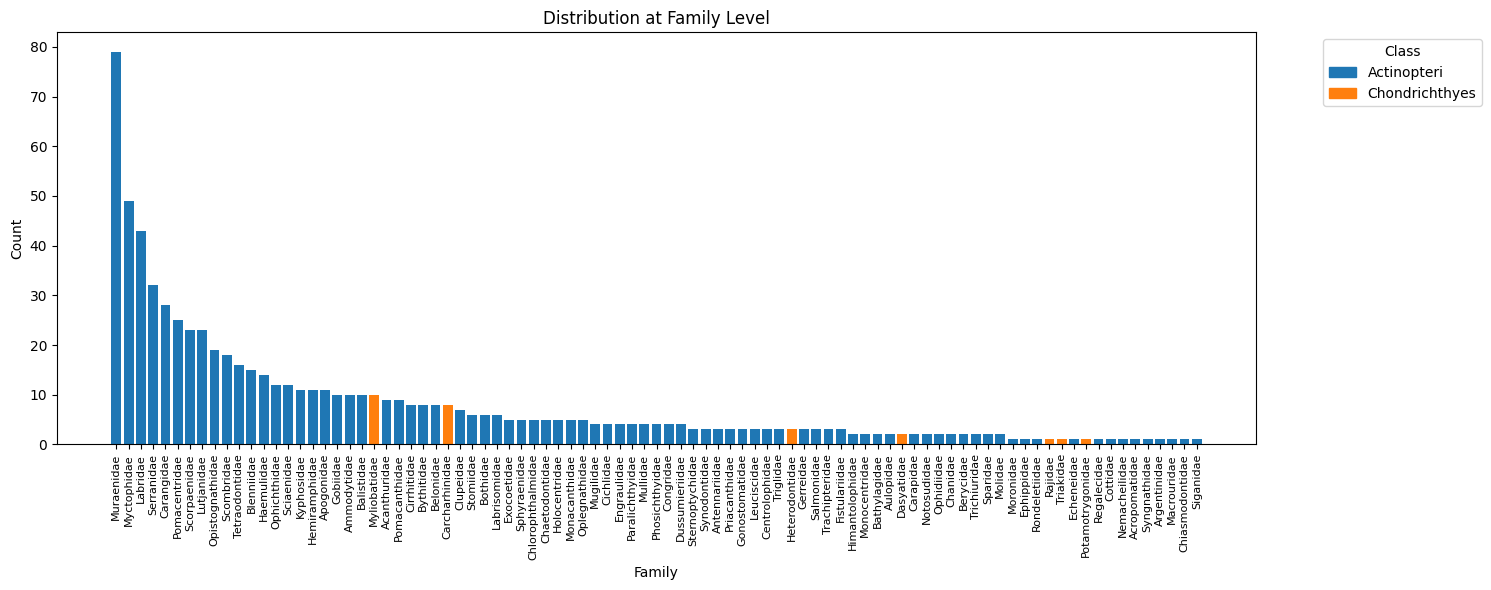

In [53]:
from src.helpers import plot_family_distribution

plot_family_distribution(fish)

In [54]:
fish_result = (fish[['B.class', 'B.family', 'B.species']]
               .dropna(subset=['B.class', 'B.family', 'B.species'], how='all')
               .dropna(subset=['B.species'], how='all')
               .drop_duplicates())

fish_result.to_csv('outputs/galapagos_fish_taxonomy.csv', index=False)

## Reconstruct food web with FishBase data

In [50]:
%%R

source("src/helpers.R")

input_file <- "outputs/galapagos_fish_taxonomy.csv"
output_file <- "outputs/galapagos_trophic_info.csv"

main(input_file, output_file)

Rows: 168 Columns: 3


── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): B.class, B.family, B.species

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(SpecCode)`
[1] "Output saved to outputs/galapagos_trophic_info.csv"


## Build food web

In [45]:
import pandas as pd
from src.helpers import create_trophic_web, save_graph


df = pd.read_csv('outputs/galapagos_trophic_info.csv')
df = df.dropna(subset=['Troph'])


G = create_trophic_web(df)
save_graph(G, 'outputs/trophic_web.tsv')

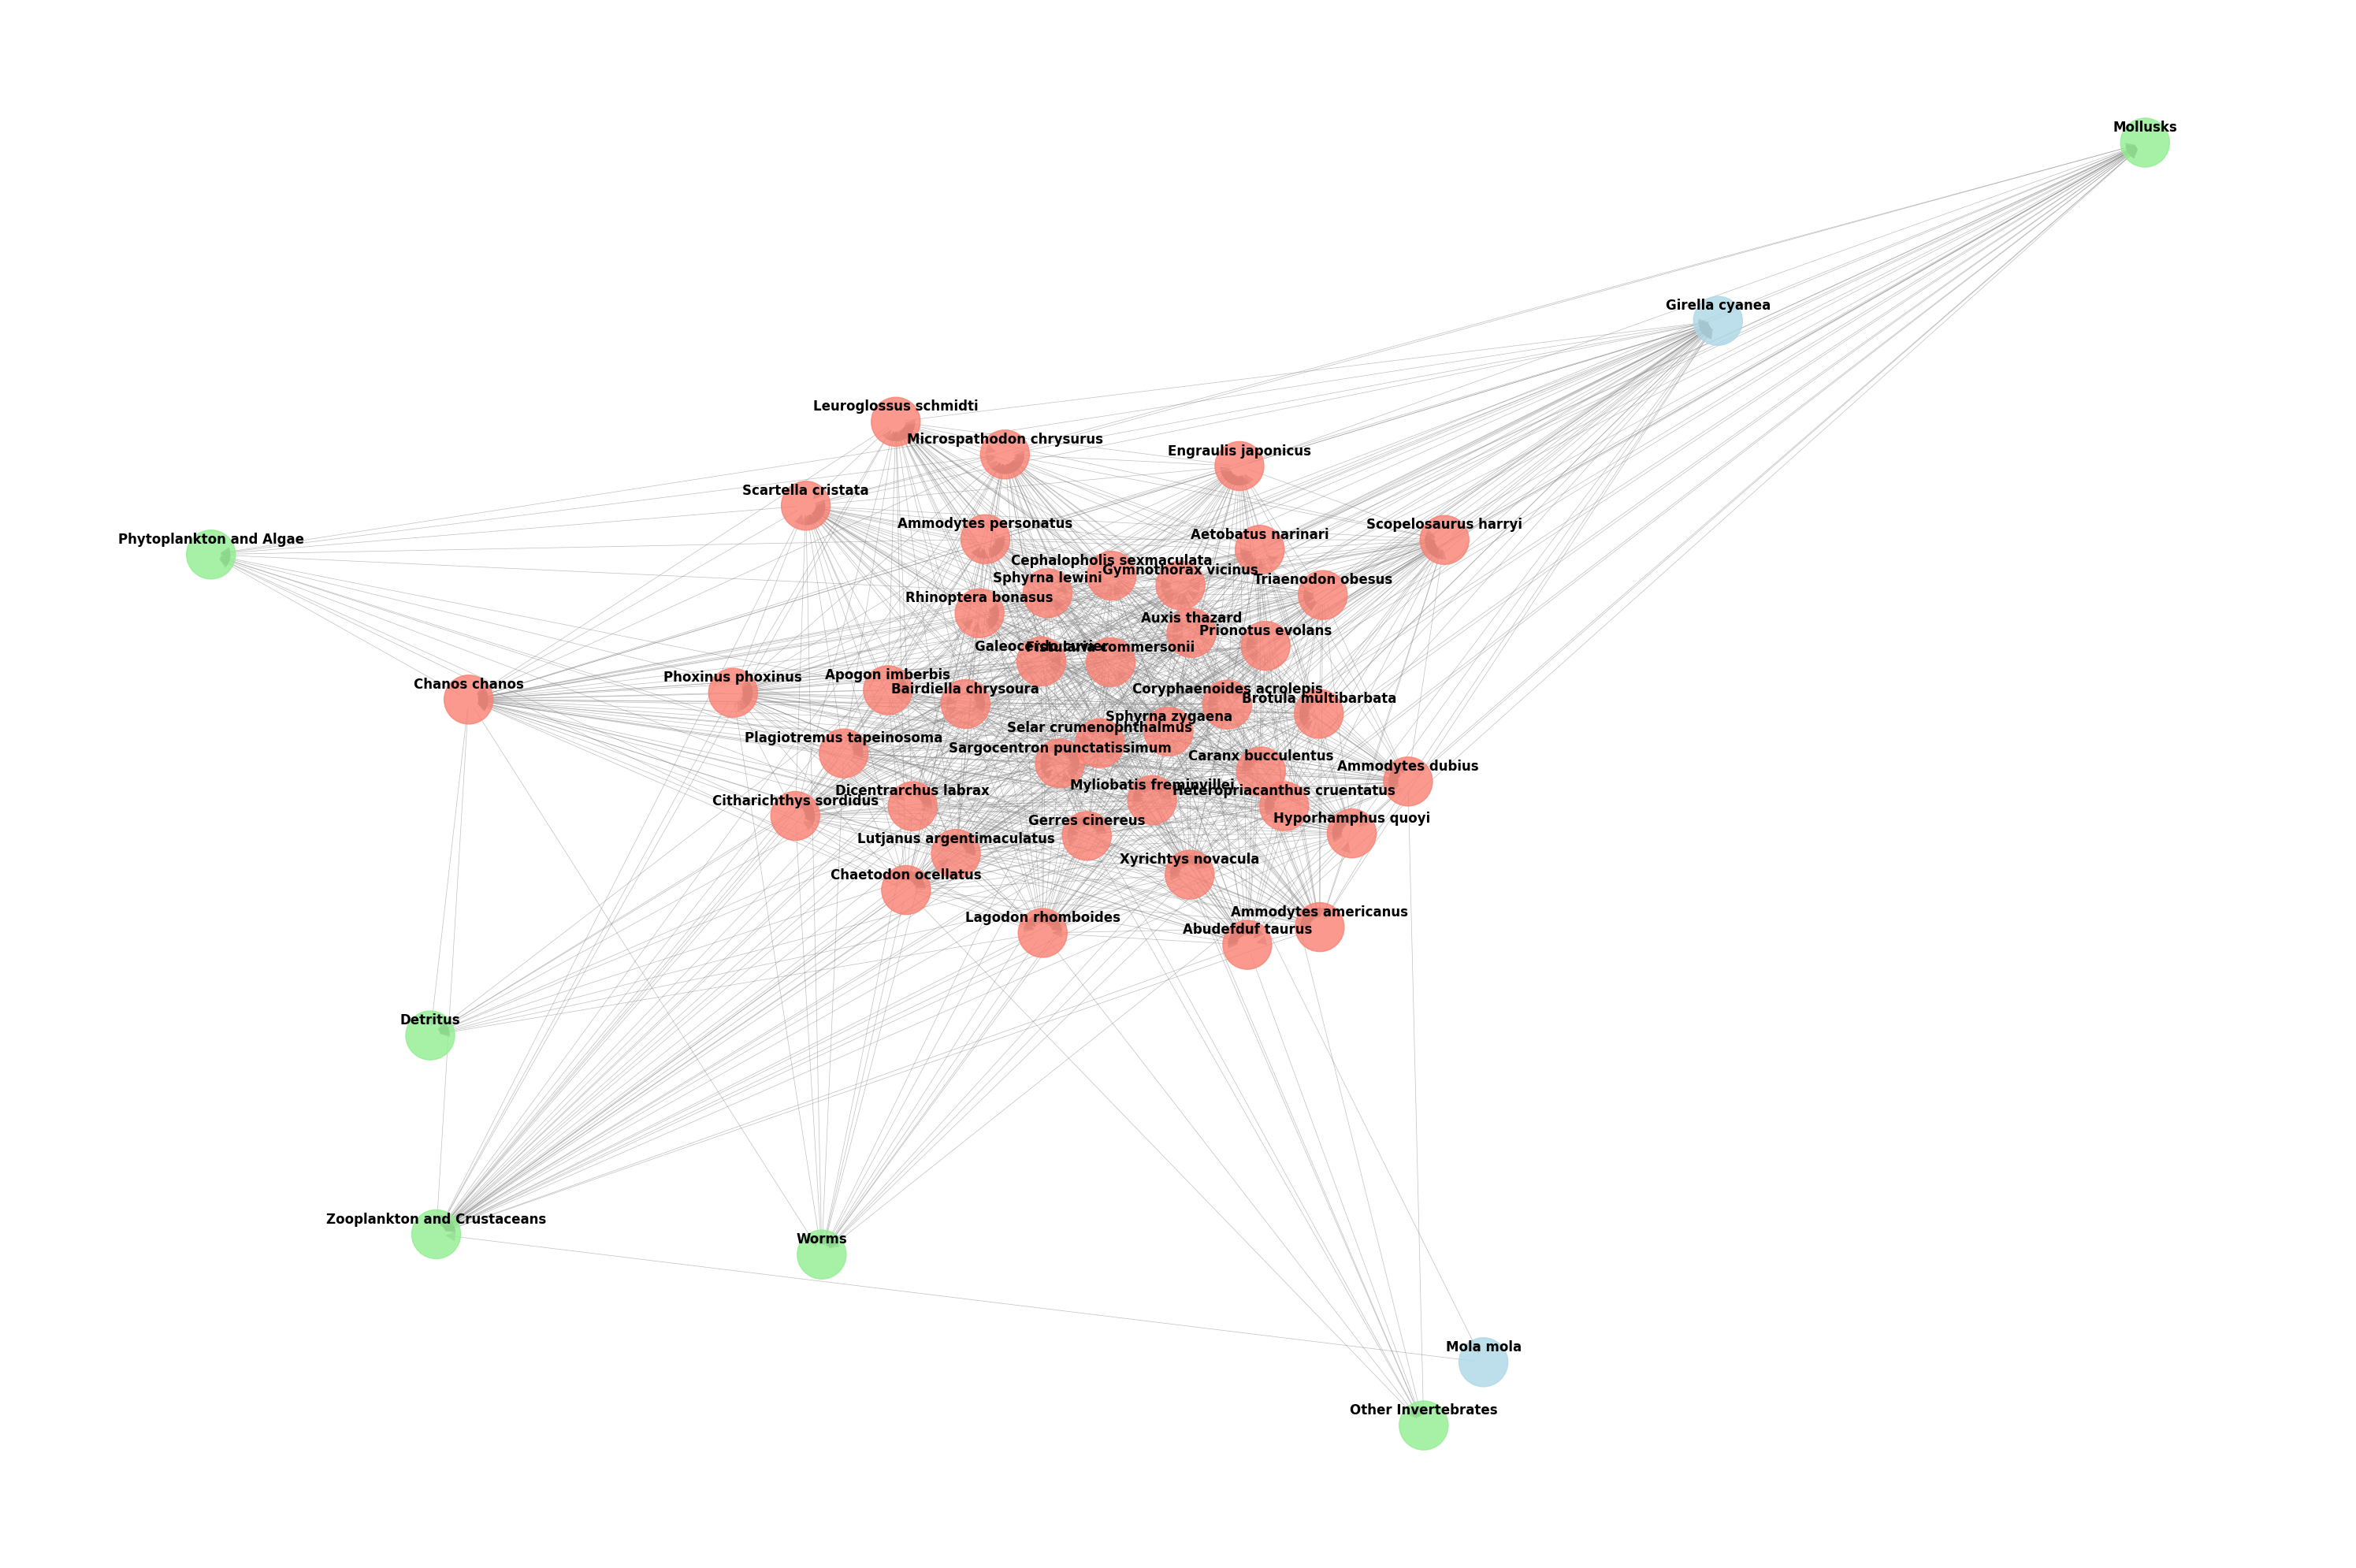

In [46]:
from src.helpers import visualize_trophic_web

visualize_trophic_web(G)